# Synthetic gravity data

### Things we have to import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image

import numpy as np
import pickle

# 3D visualization
import pyvista as pv
pv.set_jupyter_backend('panel')

from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

### Points were we compute the synthetic data

In [2]:
with open('data_points.pickle', 'rb') as f:
    data_points = pickle.load(f)

In [3]:
# number of points along x and y
print(data_points['shape'])

# minimum x, maximum x, minimum y and maximum y
print(data_points['area'])

(50, 50)
[-5000, 5000, -4000, 6000]


### Model

In [4]:
with open('synthetic_bodies.pickle', 'rb') as f:
    model = pickle.load(f)

In [5]:
print(model['prisms'].shape)

(305, 6)


### Synthetic gravity data

In [6]:
gravity_data = dict()

#### Noise-free gravity disturbace data  (in mGal)

In [7]:
# Compute the vertical component of acceleration
gravity_data['gz'] = rp.grav(
    coordinates=data_points['coordinates'], 
    prisms=model['prisms'], 
    density=model['densities'], 
    field='z'
)

#### Noise-free gravity gradient tensor data  (in Eötvös)

In [8]:
# Compute the vertical component of acceleration
gravity_data['gxx'] = rp.grav(
      coordinates=data_points['coordinates'], 
      prisms=model['prisms'], 
      density=model['densities'], 
      field='xx'
)

gravity_data['gxy'] = rp.grav(
      coordinates=data_points['coordinates'], 
      prisms=model['prisms'], 
      density=model['densities'], 
      field='xy'
)

gravity_data['gxz'] = rp.grav(
      coordinates=data_points['coordinates'], 
      prisms=model['prisms'], 
      density=model['densities'], 
      field='xz'
)

gravity_data['gyy'] = rp.grav(
      coordinates=data_points['coordinates'], 
      prisms=model['prisms'], 
      density=model['densities'], 
      field='yy'
)

gravity_data['gyz'] = rp.grav(
      coordinates=data_points['coordinates'], 
      prisms=model['prisms'], 
      density=model['densities'], 
      field='yz'
)

gravity_data['gzz'] = rp.grav(
      coordinates=data_points['coordinates'], 
      prisms=model['prisms'], 
      density=model['densities'], 
      field='zz'
)

#### Save data

In [9]:
file_name = 'gravity_data.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(gravity_data, f)

### Plot the computed gravity disturbance with Matplotlib

In [10]:
titles_tensor = ['gxx (E)', 'gxy (E)', 'gxz (E)', 'gyy (E)', 'gyz (E)', 'gzz (E)']
title_gz = ['gz (mGal)']
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']
tensor_components = ['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz']

In [11]:
ranges_tensor = []
for component in tensor_components:
    ranges_tensor.append(np.max(np.abs(gravity_data[component])))
ranges_tensor = 0.9*np.max(np.array(ranges_tensor))

In [12]:
ranges_gz = np.max(np.abs(gravity_data['gz']))

In [13]:
mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

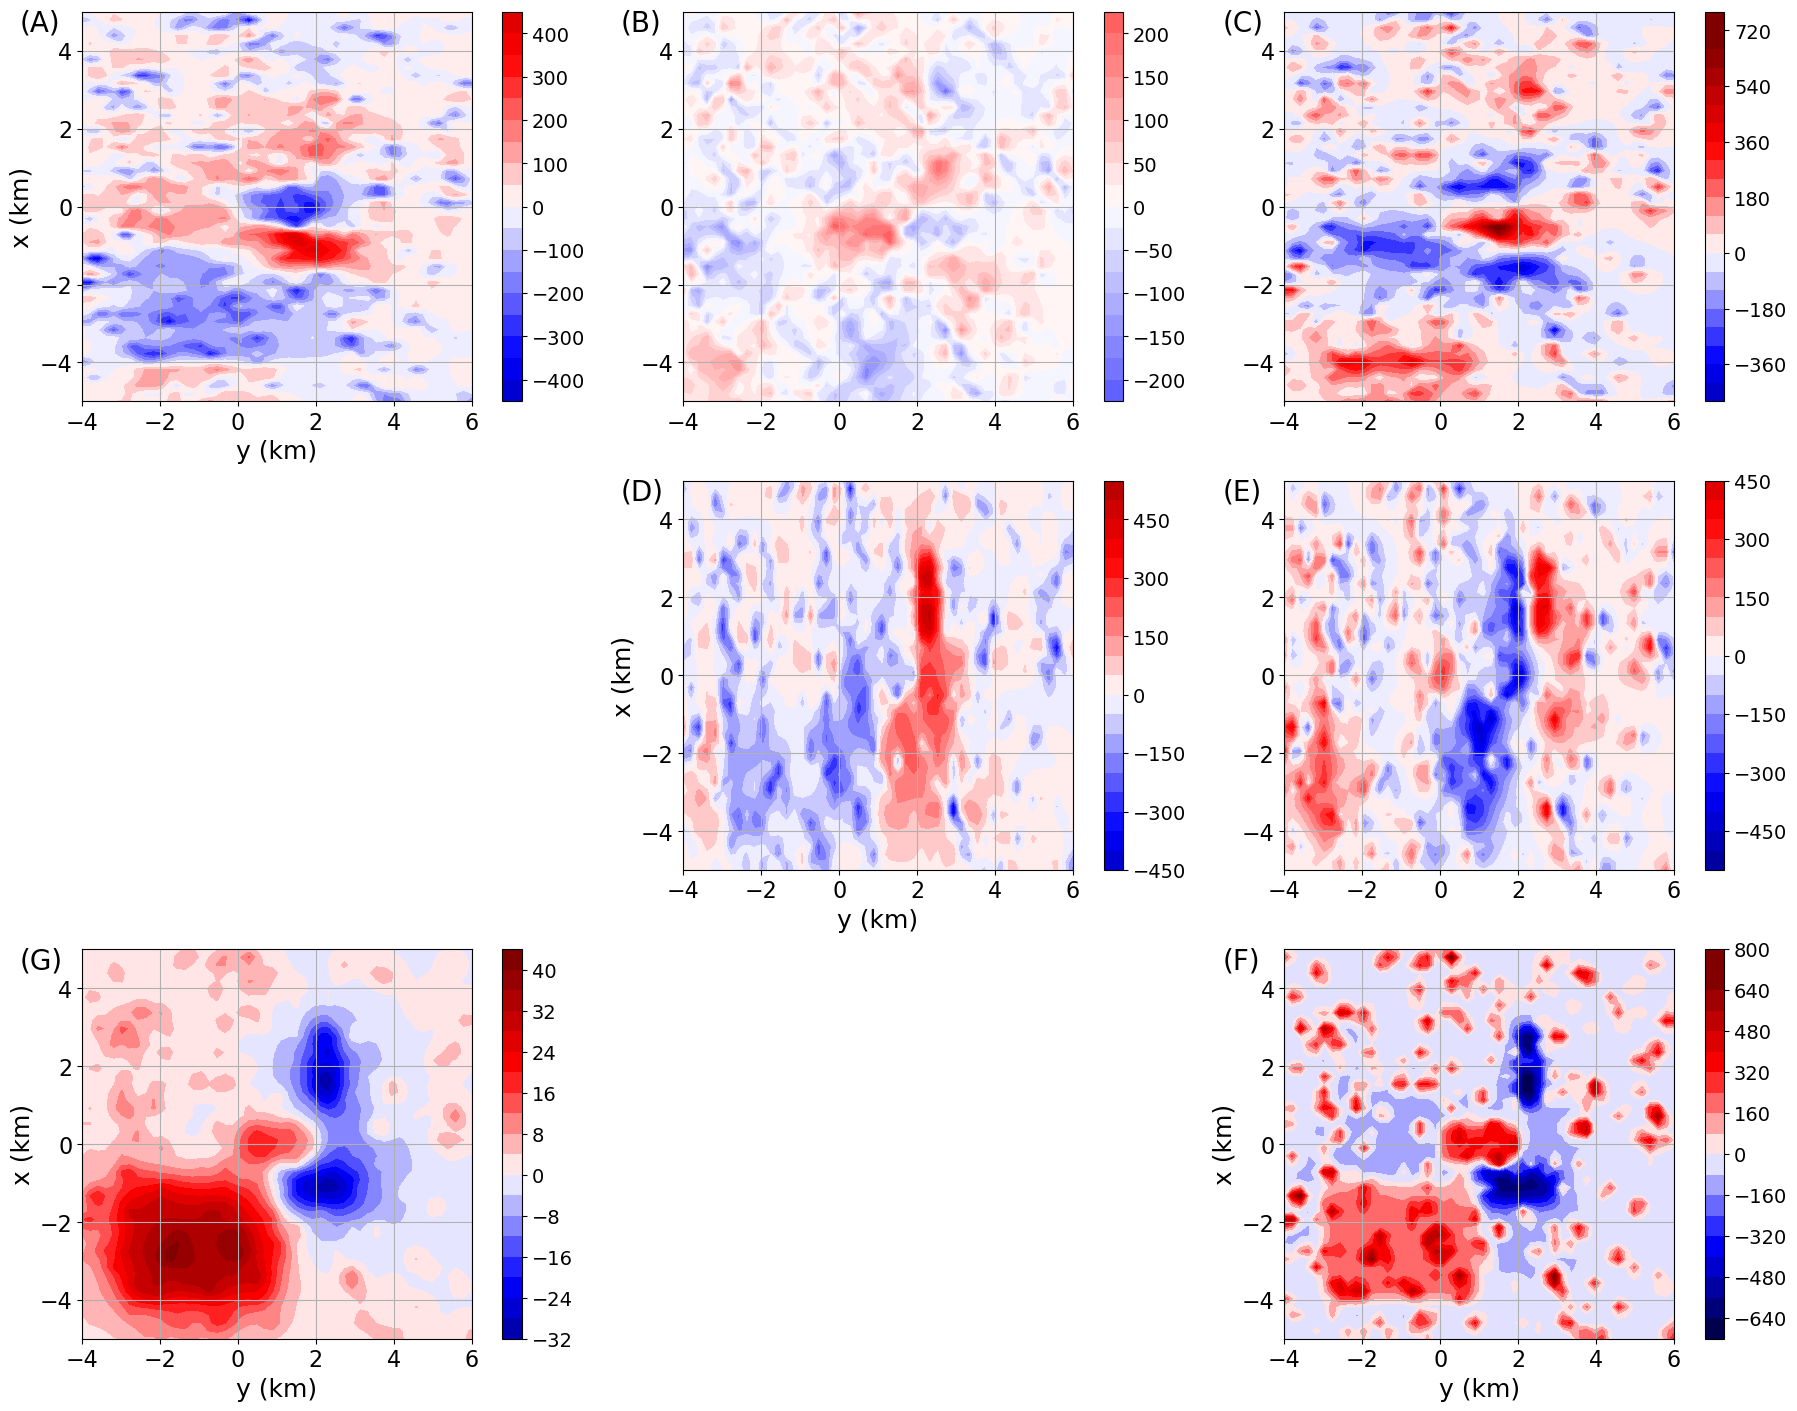

In [14]:
fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, component, title, label) in zip(
    mosaic_elements, tensor_components, titles_tensor, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                     data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                     gravity_data[component].reshape(data_points['shape']), 20, 
                     cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

# gz
ax = mosaic['g']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                 gravity_data['gz'].reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_gz, vmax=ranges_gz)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.savefig('../manuscript/Fig/noise-free-data.png', dpi= 300)
plt.show()

### Plot  and/or save the computed gravity disturbance and the model with PyVista

In [15]:
model_mesh = plf.prisms_to_pyvista(
    model['prisms'], 
    model['densities']
)

In [16]:
data_mesh = plf.data_to_surface_pyvista(
    data_points['coordinates'], 
    gravity_data['gz'])

In [17]:
pv.set_plot_theme('dark')

pl = pv.Plotter()
#pl.set_background('gray')

# parameters of data colorbar
data_sargs = dict(
    title='gz (mGal)',
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=7,
    italic=True,
    fmt="%.1f",
    font_family="arial"
)

# add data on the observation surface
pl.add_mesh(
    data_mesh,
    scalars='data',
    cmap='seismic',
    smooth_shading=True,
    scalar_bar_args=data_sargs,
    opacity=0.50
)
pl.add_mesh(data_mesh.contour(), color="black", line_width=2)

#parameters of model colorbar
model_sargs = dict(
    title='density (kg/m^3)',
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=7,
    italic=True,
    fmt="%.1f",
    font_family="arial",
)

# add model
pl.add_mesh(
    model_mesh,
    scalars='prop',
    cmap='viridis',
    lighting=True,
    scalar_bar_args=model_sargs,
    show_edges=True,
)

# set visualization parameters
# the order of the commands below changes the result
pl.camera_position = 'zy'
pl.camera.roll = -90
pl.camera.azimuth = 15
pl.camera.elevation = 30
pl.camera.zoom(1.1)

pl.show_axes()

# show the interactive plot
# pl.show()

# save the image in an external file
pl.screenshot('gz_and_synthetic_bodies.png', return_img=False)

### Plot the external image generated with PyVista

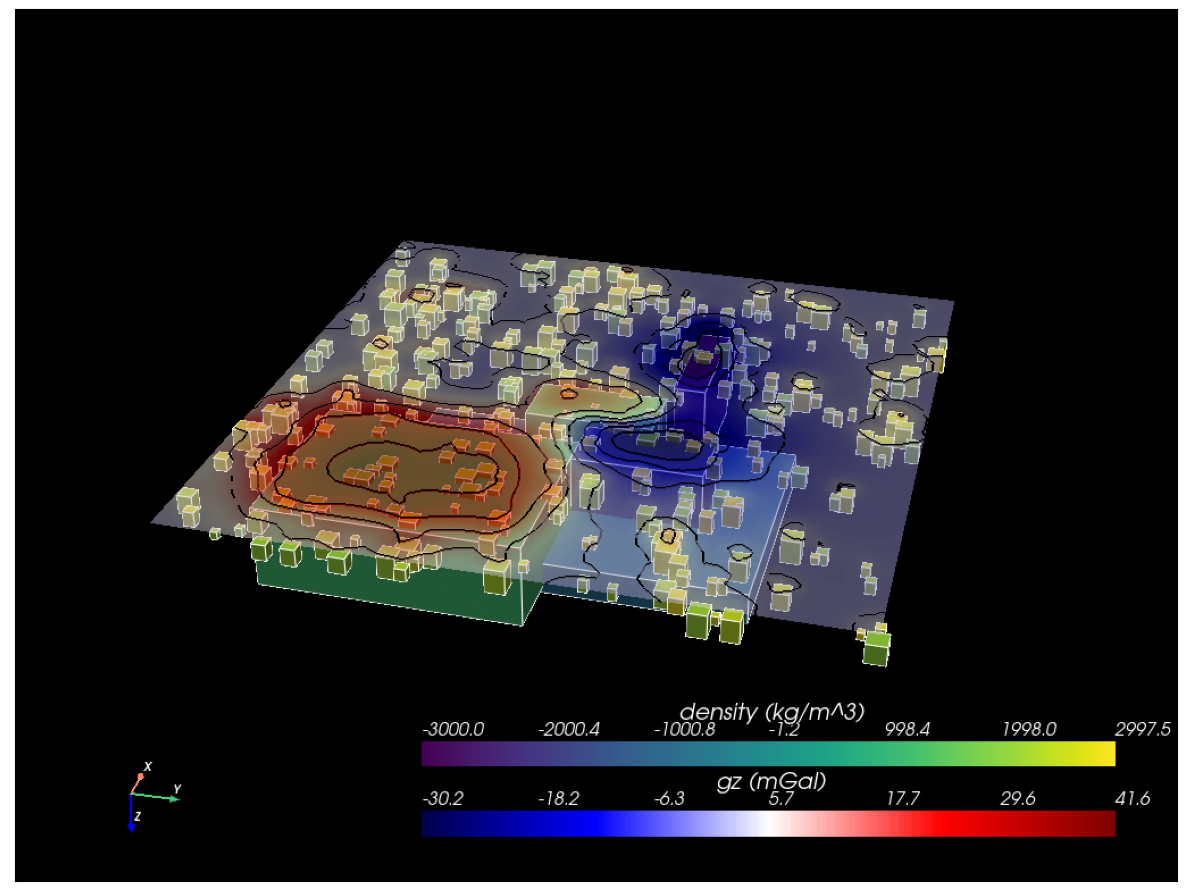

In [18]:
# read image generated with PyVista
image = Image.open('gz_and_synthetic_bodies.png')

# plot image generated with PyVista
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.xticks([]) # remove x ticks
plt.yticks([]) # remove y ticks
plt.show()